# [Polynomial Expansion for Orientation and Motion Estimation](http://www.diva-portal.org/smash/get/diva2:302485/FULLTEXT01.pdf)

Gunnar Farnebäck

## 4. Polynomial Expansion

Computes the polynomial expansion of an image frame from Sintel movie

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from PIL import Image
import scipy

**Signal**

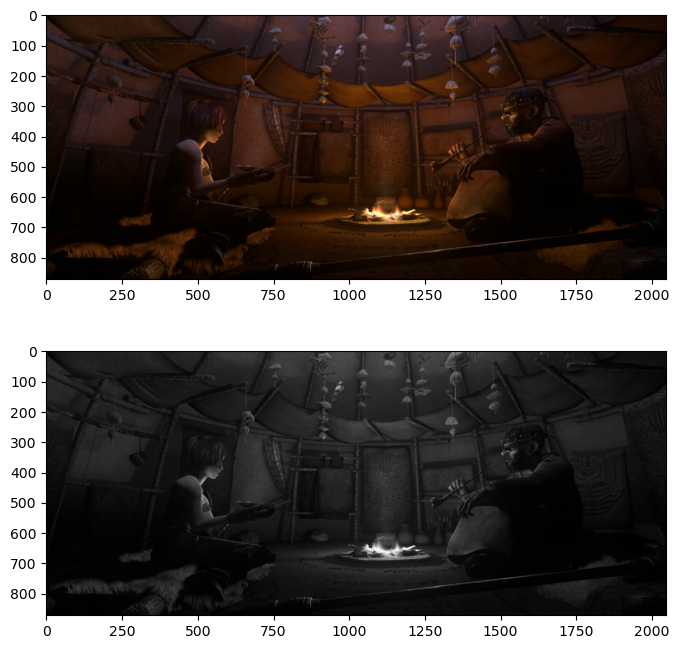

In [2]:
im = Image.open('sintel210_1.png')
f = np.array(im.convert('L'), dtype=float)

fig, (ax_im, ax_f) = plt.subplots(2, 1)
fig.set_size_inches(8, 8)
ax_im.imshow(im)
ax_f.imshow(f, cmap=cm.gray, vmin=0, vmax=255)
plt.show()

**Applicability**

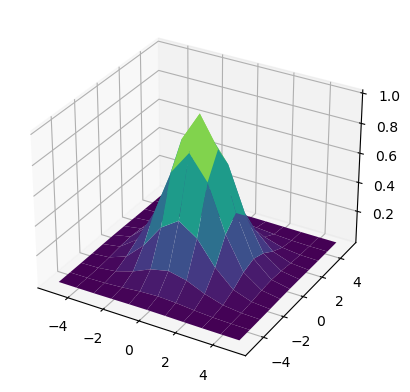

In [3]:
n = 5
sigma = 1.5

x = np.arange(-n, n + 1)

a = np.exp(-0.5 * x ** 2 / sigma ** 2)

xx, yy = np.meshgrid(x, x)

fig, ax = plt.subplots(subplot_kw={ 'projection': '3d' })
ax.plot_surface(xx, yy, np.outer(a, a), cmap=cm.viridis, vmin=0, vmax=1)
plt.show()

**Marked point**

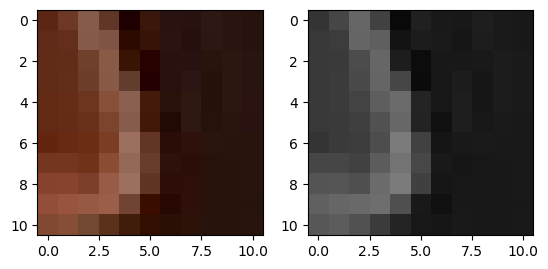

In [4]:
point = (585, 387) # Right side of Sintel's nose

fig, (ax_color, ax_gray) = plt.subplots(ncols=2)
ax_color.imshow(im.crop((point[0] - n, point[1] - n, point[0] + n + 1, point[1] + n + 1)))
ax_gray.imshow(f[point[1] - n : point[1] + n + 1, point[0] - n : point[0] + n + 1],
               cmap=cm.gray, vmin=0, vmax=255)
plt.show()

**Polynomial basis**

{1, x, y, x², y², xy}

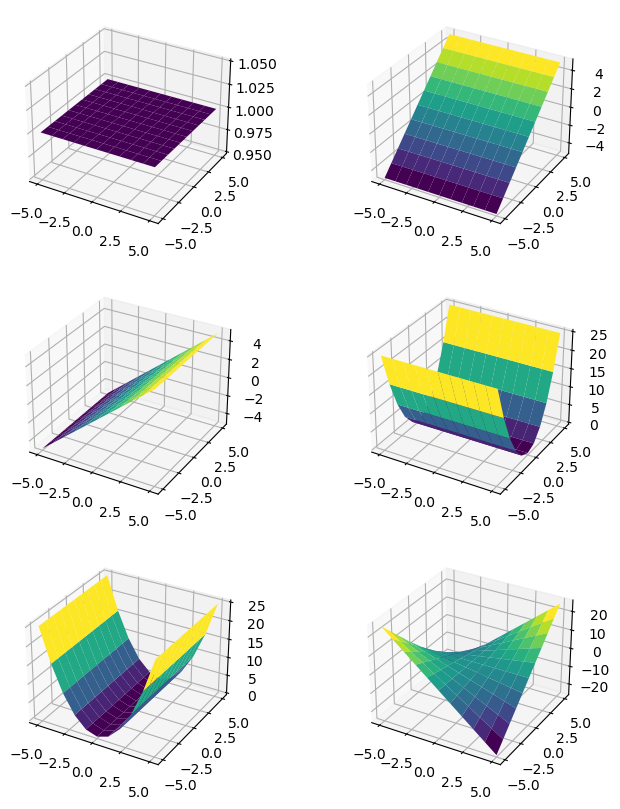

In [5]:
ones = np.ones(a.size, dtype=int)

B_x = np.stack([ones, x,    ones, x ** 2, ones,   x])
B_y = np.stack([ones, ones, x,    ones,   x ** 2, x])
B = np.einsum('ki,kj->ijk', B_x, B_y).reshape(a.size ** 2, B_x.shape[0])

fig, axs = plt.subplots(3, 2, subplot_kw={ 'projection': '3d' })
for ax, b_x, b_y in zip(axs.flat, B_x, B_y):
    ax.plot_surface(xx, yy, np.outer(b_x, b_y), cmap=cm.viridis)
fig.set_size_inches(8, 8)
plt.tight_layout(h_pad=3)
plt.show()

In [6]:
G = np.dot(np.outer(a, a).reshape(-1) * B.T, B)
invG = np.linalg.inv(G)

print(G.round(3), end='\n\n')
print(invG.round(3))

[[ 14.132   0.      0.     31.705  31.705   0.   ]
 [  0.     31.705   0.     -0.      0.      0.   ]
 [  0.      0.     31.705   0.      0.      0.   ]
 [ 31.705  -0.      0.    211.041  71.129  -0.   ]
 [ 31.705   0.     -0.     71.129 211.041  -0.   ]
 [  0.      0.      0.     -0.     -0.     71.129]]

[[ 0.143 -0.    -0.    -0.016 -0.016 -0.   ]
 [-0.     0.032 -0.     0.     0.    -0.   ]
 [-0.    -0.     0.032  0.     0.    -0.   ]
 [-0.016  0.     0.     0.007  0.     0.   ]
 [-0.016  0.     0.     0.     0.007  0.   ]
 [-0.    -0.    -0.     0.     0.     0.014]]


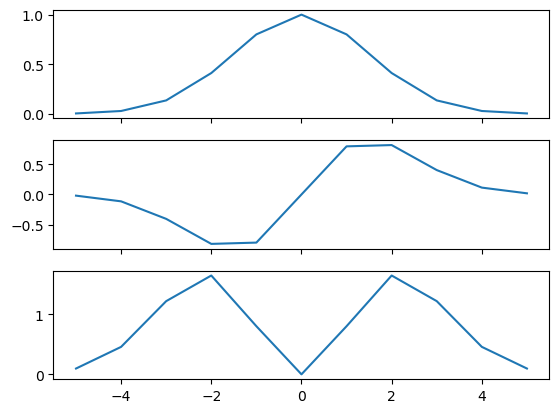

In [7]:
BWa_1D_one = a
BWa_1D_x = a * x
BWa_1D_x2 = a * x ** 2

fig, (ax_one, ax_x, ax_x2) = plt.subplots(3, sharex=True)
ax_one.plot(x, BWa_1D_one)
ax_x.plot(x, BWa_1D_x)
ax_x2.plot(x, BWa_1D_x2)
plt.show()

**Separable correlation**

x direction

In [8]:
BWaf_1D_one = scipy.ndimage.correlate1d(f, BWa_1D_one, axis=1, mode='constant')
BWaf_1D_x = scipy.ndimage.correlate1d(f, BWa_1D_x, axis=1, mode='constant')
BWaf_1D_x2 = scipy.ndimage.correlate1d(f, BWa_1D_x2, axis=1, mode='constant')

print(np.stack([BWaf_1D_one, BWaf_1D_x, BWaf_1D_x2])[:, point[1], point[0]].round(3))

[ 190.684 -132.916  430.436]


y direction

In [9]:
BWaf_one = scipy.ndimage.correlate1d(BWaf_1D_one, BWa_1D_one.T, axis=0, mode='constant')
BWaf_x = scipy.ndimage.correlate1d(BWaf_1D_x, BWa_1D_one.T, axis=0, mode='constant')
BWaf_y = scipy.ndimage.correlate1d(BWaf_1D_one, BWa_1D_x.T, axis=0, mode='constant')
BWaf_x2 = scipy.ndimage.correlate1d(BWaf_1D_x2, BWa_1D_one.T, axis=0, mode='constant')
BWaf_y2 = scipy.ndimage.correlate1d(BWaf_1D_one, BWa_1D_x2.T, axis=0, mode='constant')
BWaf_xy = scipy.ndimage.correlate1d(BWaf_1D_x, BWa_1D_x.T, axis=0, mode='constant')

BWaf = np.stack([BWaf_one, BWaf_x, BWaf_y, BWaf_x2, BWaf_y2, BWaf_xy])

print(BWaf[:, point[1], point[0]].round(3))

[ 770.408 -519.336  156.042 1681.061 1632.141  -70.301]


**Resulting coefficients**

[ 56.818 -16.38    4.922  -0.338  -0.688  -0.988]


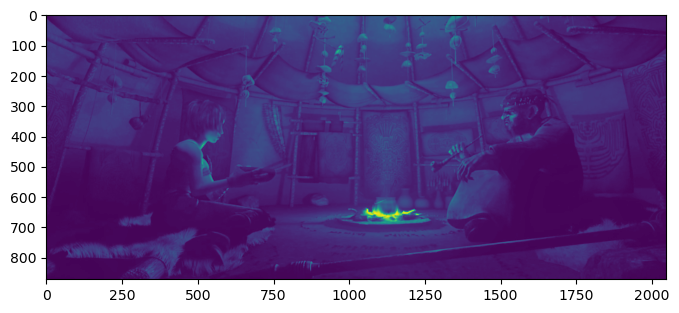

In [10]:
r = np.einsum('li,ijk', invG, BWaf)
print(r[point[1], point[0]].round(3))

fig, ax = plt.subplots()
fig.set_figwidth(8)
ax.imshow(r[..., 0])
plt.show()

**Reconstructed signal projection**

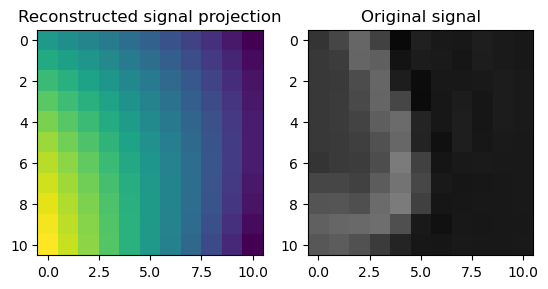

In [11]:
Br = B.dot(r[point[1], point[0]]).reshape(a.size, a.size).T

fig, (ax_projection, ax_signal) = plt.subplots(1, 2)
ax_projection.imshow(Br)
ax_projection.set_title('Reconstructed signal projection')
ax_signal.imshow(f[point[1] - n : point[1] + n + 1, point[0] - n : point[0] + n + 1],
                 cmap=cm.gray, vmin=0, vmax=255)
ax_signal.set_title('Original signal')
plt.show()